In this notebook the target spectra of Atlantic cod, polar cod and a mix is extract by single echo detection (SED), SED within tracks and average of tarcks. Includes plot comparisons of the different the target spectra.
Based on code by Chelsey McGowan-Yallop


In [160]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from tenacity import retry, stop_after_attempt
import glob

import sys, errno  


In [161]:

palette = sns.color_palette('colorblind')
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN'

In [162]:
# -- USER-DETERMINED PARAMETERS -----------------------------------------------
ppath = 'G:/AFKABAN/Pcod_190123/'
p2path = 'G:/AFKABAN/Pcod2_240123/'
apath = 'G:/AFKABAN/Acod_200123/'
pbpath = 'G:/AFKABAN/Pandalus_260123/'
kpath = 'G:/AFKABAN/Krill_270123/'


# .CSV FILES FROM ECHOVIEW -> Wideband frequency export
ac_SED_path120 = apath+"SED_tsf_120.csv" # Path to Echoview TS(f) file
ac_SED_path200 = apath+"SED_tsf_200.csv" # Path to Echoview TS(f) file

pc_SED_path120 = ppath+"SED_tsf_120.csv" # Path to Echoview TS(f) file
pc_SED_path200 = ppath+"SED_tsf_200.csv" # Path to Echoview TS(f) file

pc2_SED_path120 = p2path+"SED_tsf_120.csv" # Path to Echoview TS(f) file
pc2_SED_path200 = p2path+"SED_tsf_200.csv" # Path to Echoview TS(f) file

pb_SED_path120 = pbpath+"SED_tsf_120.csv" # Path to Echoview TS(f) file
pb_SED_path200 = pbpath+"SED_tsf_200.csv" # Path to Echoview TS(f) file
pb_tracks_path = pbpath+"SED_tsf_tracks.csv"

k_SED_path120 = kpath+"SED_tsf_120.csv" # Path to Echoview TS(f) file
k_SED_path200 = kpath+"SED_tsf_200.csv" # Path to Echoview TS(f) file

min_range = 1.0 # Apply min range (m) to targets, else None
max_range = 7.0 # Apply max range (m) to targets, else None


In [163]:
def tsf_import(file_path):

    """
    This function imports wideband frequency response .csv files exported from
    Echoview and performs some basic housekeeping.
    
    PARAMETERS:
        file_path: Path to wideband frequency response .csv file from Echoview.
        
    RETURNS:
        df: Pandas dataframe.
    """
    
    def get_datetime(df, avg_flag):
        """
        Convert Echoview timestamps in imported .csv to datetime.
        """
        if avg_flag:
            df['Ping_microseconds_start'] = df.Ping_millisecond_start * 1000
            df['Ping_microseconds_start'] = [timedelta(microseconds = i) for i in df['Ping_microseconds_start']]
            df['Datetime'] = df['Ping_date_start_Ping_time_start'] + df['Ping_microseconds_start']
            df.drop(columns=['Ping_date_start_Ping_time_start',
                             'Ping_millisecond_start',
                             'Ping_microseconds_start'], 
                    inplace=True)
        
        else:
            df['Ping_microseconds'] = df.Ping_milliseconds * 1000
            df['Ping_microseconds'] = [timedelta(microseconds = i) for i in df['Ping_microseconds']]
            df['Datetime'] = df['Ping_date_Ping_time'] + df['Ping_microseconds']
            df.drop(columns=['Ping_date_Ping_time',
                             'Ping_milliseconds',
                             'Ping_microseconds'],
                    inplace=True)
        
        return df
    
    if "trackavg.csv" in file_path:
        parse_cols = ['Ping_date_start', 'Ping_time_start']
        ind_col = None
        avg_flag = True
    else:
        parse_cols = ['Ping_date', 'Ping_time']
        ind_col = 'Target_index'
        avg_flag = False
        
    
    transposed_path = file_path[:-4] + '_transposed.csv'
    if os.path.isfile(transposed_path) == True:
        df = pd.read_csv(transposed_path,
                         index_col=ind_col,
                         skiprows=1,
                         skipfooter=2,
                         engine='python',
                         parse_dates=[parse_cols])
    else:
        df = pd.read_csv(file_path, low_memory=False).T
        file_path = transposed_path
        df.to_csv(path_or_buf=file_path)
        print('A transposed TS(f) file was created at: \n' + str(file_path))    
        df = pd.read_csv(file_path,
                         index_col=ind_col,
                         skiprows=1,
                         skipfooter=2,
                         engine='python',
                         parse_dates=[parse_cols])
    
    df = get_datetime(df, avg_flag)
    
    return df

## Create Target Strength dataframes

In [164]:
# Atlantic cod
acSED_df_120 = tsf_import(ac_SED_path120)
acSED_df_200 = tsf_import(ac_SED_path200)

# Polar cod
pcSED_df_120 = tsf_import(pc_SED_path120)
pcSED_df_200 = tsf_import(pc_SED_path200)

# Polar cod2
pc2SED_df_120 = tsf_import(pc2_SED_path120)
pc2SED_df_200 = tsf_import(pc2_SED_path200)

# Pandalus borealis
pbSED_df_120 = tsf_import(pb_SED_path120)
pbSED_df_200 = tsf_import(pb_SED_path200)


# Krill 120 (2023) and 200 (2022)
kSED_df_120 = tsf_import(k_SED_path120)
kSED_df_200 = tsf_import(k_SED_path200)



A transposed TS(f) file was created at: 
G:/AFKABAN/Krill_270123/SED_tsf_120_transposed.csv
A transposed TS(f) file was created at: 
G:/AFKABAN/Krill_270123/SED_tsf_200_transposed.csv


### extract TS(f) components
And remove 162-170 kHz bandwidth because of poor calibration results.

#### Polar cod

In [165]:
freqs_120 = pcSED_df_120.columns[5:-21].values.astype(np.float64)
pc_ts_120 = pcSED_df_120.iloc[:,5:-21]
pc_ts_120[pc_ts_120<-9999]=np.nan

In [166]:
freqs_200 = pcSED_df_200.columns[3:-1].values.astype(np.float64)
pc_ts_200 = pcSED_df_200.iloc[:,3:-1]
pc_ts_200[pc_ts_200<-9999]=np.nan

#### Polar cod 2

In [167]:
freqs_120 = pc2SED_df_120.columns[5:-21].values.astype(np.float64)
pc2_ts_120 = pc2SED_df_120.iloc[:,5:-21]
pc2_ts_120[pc2_ts_120<-9999]=np.nan

In [168]:
freqs_200 = pc2SED_df_200.columns[3:-1].values.astype(np.float64)
pc2_ts_200 = pc2SED_df_200.iloc[:,3:-1]
pc2_ts_200[pc2_ts_200<-9999]=np.nan

#### Atlantic cod

In [169]:
freqs_120 = acSED_df_120.columns[5:-21].values.astype(np.float64)
ac_ts_120 = acSED_df_120.iloc[:,5:-21]
ac_ts_120[ac_ts_120<-9999]=np.nan

In [170]:
freqs_200 = acSED_df_200.columns[3:-1].values.astype(np.float64)
ac_ts_200 = acSED_df_200.iloc[:,3:-1]
ac_ts_200[ac_ts_200<-9999]=np.nan

#### Pandalus shrimp

In [171]:
freqs_120 = pbSED_df_120.columns[5:-21].values.astype(np.float64)
pb_ts_120 = pbSED_df_120.iloc[:,5:-21]
pb_ts_120[pb_ts_120<-9999]=np.nan

In [172]:
freqs_200 = pbSED_df_200.columns[3:-1].values.astype(np.float64)
pb_ts_200 = pbSED_df_200.iloc[:,3:-1]
pb_ts_200[pb_ts_200<-9999]=np.nan

#### Krill

In [173]:
freqs_120 = kSED_df_120.columns[5:-21].values.astype(np.float64)
k_ts_120 = kSED_df_120.iloc[:,5:-21]
k_ts_120[k_ts_120<-9999]=np.nan

In [174]:
freqs_200 = kSED_df_200.columns[3:-1].values.astype(np.float64)
k_ts_200 = kSED_df_200.iloc[:,3:-1]
k_ts_200[k_ts_200<-9999]=np.nan

### plot 

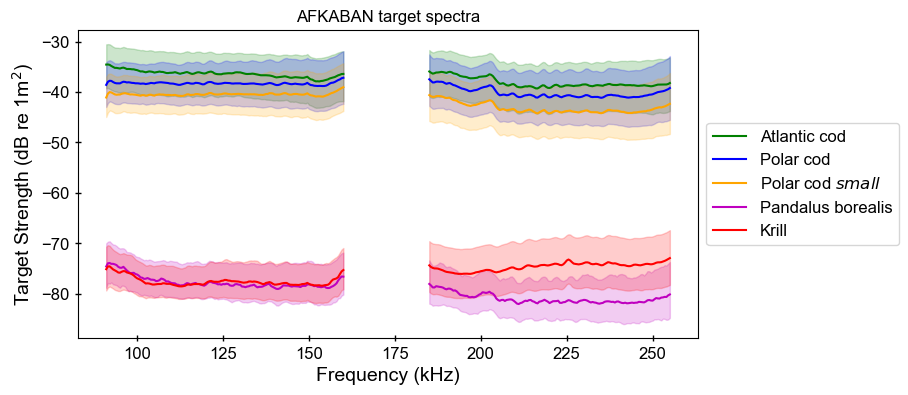

In [175]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

# Atlantic cod
ax.plot(freqs_120,ac_ts_120.median(), 'g', label='Atlantic cod')
ax.fill_between(freqs_120,ac_ts_120.quantile(q=0.25),ac_ts_120.quantile(q=0.75),alpha=0.2, color='g')

ax.plot(freqs_200,ac_ts_200.median(), 'g')
ax.fill_between(freqs_200,ac_ts_200.quantile(q=0.25),ac_ts_200.quantile(q=0.75),alpha=0.2, color='g')

# Polar cod
ax.plot(freqs_120,pc_ts_120.median(), 'b', label='Polar cod')
ax.fill_between(freqs_120,pc_ts_120.quantile(q=0.25),pc_ts_120.quantile(q=0.75),alpha=0.2, color='b')

ax.plot(freqs_200,pc_ts_200.median(), 'b')
ax.fill_between(freqs_200,pc_ts_200.quantile(q=0.25),pc_ts_200.quantile(q=0.75),alpha=0.2, color='b')

# Polar cod2
ax.plot(freqs_120,pc2_ts_120.median(), 'orange', label='Polar cod $small$')
ax.fill_between(freqs_120,pc2_ts_120.quantile(q=0.25),pc2_ts_120.quantile(q=0.75),alpha=0.2, color='orange')

ax.plot(freqs_200,pc2_ts_200.median(), 'orange')
ax.fill_between(freqs_200,pc2_ts_200.quantile(q=0.25),pc2_ts_200.quantile(q=0.75),alpha=0.2, color='orange')


# Pandalus shrimp
ax.plot(freqs_120,pb_ts_120.median(), 'm', label='Pandalus borealis')
ax.fill_between(freqs_120,pb_ts_120.quantile(q=0.25),pb_ts_120.quantile(q=0.75),alpha=0.2, color='m')

ax.plot(freqs_200,pb_ts_200.median(), 'm')
ax.fill_between(freqs_200,pb_ts_200.quantile(q=0.25),pb_ts_200.quantile(q=0.75),alpha=0.2, color='m')

# Krill
ax.plot(freqs_120,k_ts_120.median(), 'r', label='Krill')
ax.fill_between(freqs_120,k_ts_120.quantile(q=0.25),k_ts_120.quantile(q=0.75),alpha=0.2, color='r')

ax.plot(freqs_200,k_ts_200.median(), 'r')
ax.fill_between(freqs_200,k_ts_200.quantile(q=0.25),k_ts_200.quantile(q=0.75),alpha=0.2, color='r')

ax.set_ylabel('Target Strength (dB re 1m$^2$)')
ax.set_title('AFKABAN target spectra')
ax.set_xlabel('Frequency (kHz)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Atlantic cod and polar cod are essentially following the same pattern. Northern shrimp has a more distinct pattern (even when they are al averaged over the same amount of observations).

## Check out tracks

In [176]:
pb_tracks_df = tsf_import(pb_tracks_path)

In [177]:
bad_bandwidth = np.where((freqs>162) & (freqs<170.5))[0]

In [178]:
# remove 162 - 170 bandwidth
pb_tracks_df = pb_tracks_df.drop(pb_tracks_df.iloc[:,bad_bandwidth],axis=1)

# determine remaining ferquencies and TS
freqs = pb_tracks_df.columns[4:-1].values.astype(np.float64)
pb_ts_tracks = pb_tracks_df.iloc[:,4:-1]
pb_ts_tracks[pb_ts_tracks<-9999]=np.nan

IndexError: index 70 is out of bounds for axis 0 with size 70

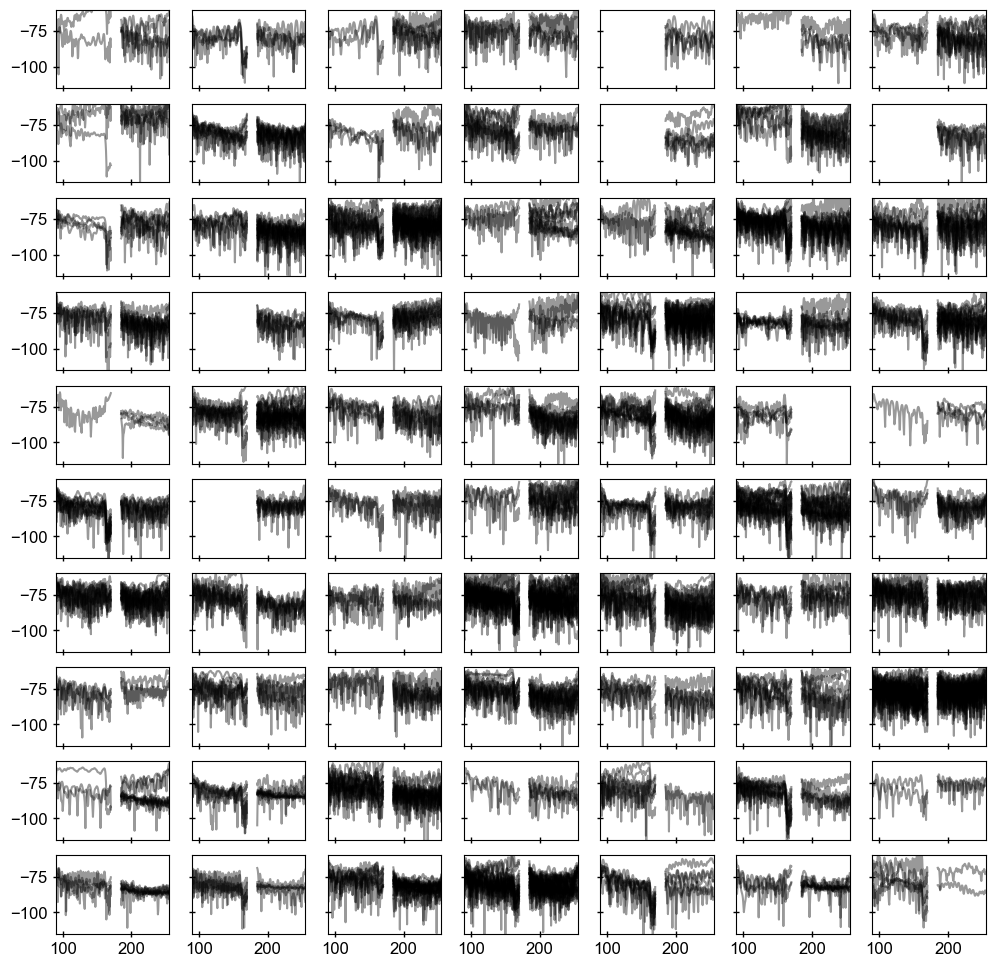

In [179]:
# select track
n_tracks = pb_tracks_df['Region_name'].unique()
fig, ax = plt.subplots(10,7,figsize=(12,12), sharex=True, sharey=True)
ax = ax.flatten()
for i_track in range(len(n_tracks)):
    track_inds = pb_tracks_df['Region_name']==n_tracks[i_track]
    ax[i_track].plot(freqs, pb_ts_tracks[track_inds].T, 'k', alpha=0.4)
    ax[i_track].set_ylim([-115,-60])
    ax[i_track].set_xlim([90,255])